<a href="https://colab.research.google.com/github/jamesfloe/cap-comp215/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Traffic Jams and Collisions: *a study into distracted driving.*

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com),  https://towardsdatascience.com/simulating-traffic-flow-in-python-ee1eab4dd20f.

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [ ]:
import os
if not os.path.exists('utils.py'):
    !wget https://raw.githubusercontent.com/AllenDowney/ThinkComplexity2/master/notebooks/utils.py
if not os.path.exists('Cell2D.py'):
  !wget  https://raw.githubusercontent.com/pearcej/complex-colab/master/notebooks/Cell2D.py

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from utils import decorate

Here's the `Driver` class from Chapter 12.2.
- The attributes loc and speed are the location and speed of the driver.
- The start attribute is simply to set the odometer of the driver.


In [ ]:
class Driver:
    
    def __init__(self, x, v=4):
        """Initialize the attributes.
        
        loc: position on track, in miles
        speed: speed in miles per hour
        """
        self.start = x
        self.x = x
        self.v = v

    def choose_acceleration(self, dist):
        """Chooses acceleration based on distance.
        
        dist: distance from the car in front
        
        returns: acceleration
        """
        return 1
        
    def set_odometer(self):
        self.start = self.x
        
    def read_odometer(self):
        return self.x - self.start

Here's the `Highway` class from Chapter 12.2.
- n is the number of cars. 
- length is the length of the highway.
- eps is the amount of random noise added to the system.

Creating list of driver objects:
- locs contains the locations of the drivers; the NumPy function linspace creates an array of n locations equally spaced between 0 and length. More here: https://numpy.org/doc/stable/reference/generated/numpy.linspace.html
- The line: self.drivers = [Driver(loc) for loc in locs] creates a list of Driver objects for every location in locs.
-The following for loop makes it so each driver contains a reference for the next driver.

The step method applies the move method for each driver in the list of driver objects.

The move method sets the acceleration (acc) of the driver, and adds it to the preset speed of the driver. It then updates the drivers speed and location.
- Random *noise* is applied to the speed. This is done by multiplying speed by np.random.uniform, which draws random float samples in a given interval. More on this here: https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html.

The get coordinates method then transforms the drivers locations to coordinates on a unit circle.

The draw method uses matplot to draw the unit circle.


In [ ]:
from Cell2D import Cell2D

class Highway(Cell2D):
    
    max_acc = 1
    min_acc = -10
    speed_limit = 40
    
    def __init__(self, n=10, length=1000, eps=0, constructor=Driver):
        """Initializes the attributes.
        
        n: number of drivers
        length: length of the track
        eps: variability in speed
        constructor: function used to instantiate drivers
        """
        self.length = length
        self.eps = eps
        self.crashes = 0

        # create the drivers
        xs = np.linspace(0, length, n, endpoint=False)
        self.drivers = [constructor(x) for x in xs]
        
        # and link them up
        for i in range(n):
            j = (i+1) % n
            self.drivers[i].next = self.drivers[j]
            
    def step(self):
        """Performs one time step."""
        for driver in self.drivers:
            self.move(driver)
            
    def move(self, driver):
        """Updates `driver`.
        
        driver: Driver object
        """
        # get the distance to the next driver
        dist = self.distance(driver)

        # Let driver choose
        acc = driver.choose_acceleration(dist)
        acc = min(acc, self.max_acc)
        acc = max(acc, self.min_acc)
        v = driver.v + acc # acc is simply added to preset driver speed
            
        # add random noise to speed
        v *= np.random.uniform(1-self.eps, 1+self.eps)
        
        # keep it nonnegative and under the speed limit
        v = max(v, 0)
        v = min(v, self.speed_limit)
        
        # if current speed would collide with next driver, stop
        if v > dist:
            v = 0
            self.crashes += 1
            
        # update speed and loc
        driver.v = v
        driver.x += v
            
    def distance(self, driver):
        """Distance from `driver` to next driver.
        
        driver: Driver object
        """
        dist = driver.next.x - driver.x
        # fix wraparound
        if dist < 0:
            dist += self.length
        return dist
    
    def set_odometers(self):
        return [driver.set_odometer()
                for driver in self.drivers] 
    
    def read_odometers(self):
        return np.mean([driver.read_odometer()
                        for driver in self.drivers])
    
    def draw(self):
        """Draws the drivers and shows collisions.
        """
        drivers = self.drivers
        xs, ys = self.get_coords(drivers)
        plt.plot(xs, ys, 'bs', markersize=10, alpha=0.7)
        
        stopped = [driver for driver in self.drivers 
                  if driver.v==0]
        xs, ys = self.get_coords(stopped, r=0.8)
        plt.plot(xs, ys, 'r^', markersize=12, alpha=0.7)
        
        plt.axis('off')
        plt.axis('equal')
        plt.xlim([-1.05, 1.05])
        plt.ylim([-1.05, 1.05])

    def get_coords(self, drivers, r=1):
        """Gets the coordinates of the drivers.
        
        Transforms from (row, col) to (x, y).
        
        drivers: sequence of Driver
        r: radius of the circle
        
        returns: tuple of sequences, (xs, ys)
        """
        xvals = np.array([driver.x for driver in drivers]) # Creates a numpy array of every drivers location.
        xvals *= 2 * np.pi / self.length # Multiplies each location by the perimeter of the circle.
        xs = r * np.cos(xvals) # Takes the cosine of each location, effectively having an x coordinate in a unit circle.
        ys = r * np.sin(xvals) # does the same but with sine and they y coordinate
        return xs, ys

Make the animation:

In [ ]:
highway = Highway(30, eps=0.02)
highway.animate(frames=40, interval=0.2)

And generate the figure:

In [ ]:
from utils import three_frame

highway = Highway(30, eps=0.02)
three_frame(highway, [16, 1, 1], seed=22)
plt.show('figs/chap10-1')

Explore relationship between *eps* and average speed.

In [ ]:
def run_simulation(eps, constructor=Driver, iters=100):
    res = []
    for n in range(5, 100, 5):
        highway = Highway(n, eps=eps, constructor=constructor)
        for i in range(iters):
            highway.step()

        highway.set_odometers()
        for i in range(iters):
            highway.step()

        res.append((n, highway.read_odometers() / iters))
    
    return np.transpose(res)

In [ ]:


np.random.seed(20)
from utils import set_palette
set_palette('Blues', 4, reverse=True)

for eps in [0.0, 0.001, 0.01]:
    xs, ys = run_simulation(eps)
    plt.plot(xs, ys, label='eps=%g' % eps)
    
decorate(xlabel='Number of cars',
                 ylabel='Average speed',
                 xlim=[0, 100], ylim=[0, 42])

plt.show('figs/chap10-2')



Improved Model:
- The given model does not allow cars to decelerate according to the speed, or distance, of the car infront of them
- In real life, drivers are able to easily adjust their speed and acceleration by observing the behaviour of the car infront of them, thus preventing the collision.

The improved model will overwrite both classes.
- Drivers will be able to decelerate.
- A probability (distractedp) will be added to the Driver class. This will be the probability a driver is distracted or not.

Improved Driver class:
- An acceleration parameter will be added to the driver,
- a distracted parameter, indicating wether the driver is distracted or not, will also be added.
- The choose_acceleration method will be overwritten with an equation derived by Treiber, Hennecke et Helbing in 2000. A paper on it can be found here: https://journals.aps.org/pre/abstract/10.1103/PhysRevE.62.1805. The simplified equation to be added to python can be found here. https://towardsdatascience.com/simulating-traffic-flow-in-python-ee1eab4dd20f


In [241]:
class improvedDriver():

    def __init__(self, x, distractedp, a=0, v=40):
        """Initialize the attributes.
        
        x: position on track, in miles
        v: speed in miles per hour
        a: acceleration in mp/h*2
        distractedp: Wether a driver is distracted or not,
        0 indicates not distracted, 1 indicates distracted
        """
        self.start = x
        self.x = x
        self.a = a
        self.v = v
        self.distracted = distractedp

    def choose_acceleration(self, delta_x, delta_v, a_max, a_min, speed_limit, lead):
      """Chooses acceleration based on delta_x, delta_v, a_max, a_min, speed_limit, and lead.
        
      delta_x: distance from the car in front
      delta_v: difference of velocity of the next and current driver
      a_max: overall maximum acceleration (preferably a comfortable one)
      a_min: overall minium acceleration (preferably a comfortable one)
      speed_limit: maximum velocity for each car
      lead: desired distance from the car infront
        
      returns: acceleration
      """
      alpha = 0 
      sqrt_ab = 2*np.sqrt(a_max*a_min) 
      alpha = (lead + max(0, self.v + delta_v*self.v/sqrt_ab)) / delta_x # Equation which Go

      if self.distracted == 1:
        acc = float(np.random.choice([ 0, a_max * (1-(self.v/speed_limit)**4 - alpha**2) ]))
      else:
        acc = a_max * (1-(self.v/speed_limit)**4 - alpha**2)
      return acc

    def set_odometer(self):
        self.start = self.x
        
    def read_odometer(self):
        return self.x - self.start

In [345]:

class improvedHighway(Highway):
    
    def __init__(self, n=10, a_max=1.5, a_min=5, speed_limit=40, length=1000, eps=0, distractedp=0.0, constructor=improvedDriver):
        """Initializes the attributes.
        
        n: number of drivers
        length: length of the track
        eps: variability in speed
        distratedp: probability of a driver being 'distracted'
        constructor: function used to instantiate drivers
        """
        self.speed_limit = speed_limit
        self.a_max = a_max
        self.a_min = a_min
        self.length = length
        self.eps = eps
        self.crashes = 0

        # create the drivers
        xvalues = np.linspace(0, length, n, endpoint=False)
        distractedDrivers = [int(np.random.choice(2,1,p=[1-distractedp,distractedp])) for i in range(n)] # Choose which drivers are distracted
        both = zip(xvalues, distractedDrivers)
        self.drivers = [constructor(xvalue, distracted) for xvalue, distracted in both]

        # and link them up
        for i in range(n):
            j = (i+1) % n
            self.drivers[i].next = self.drivers[j]

    def move(self, driver):
        """Updates `driver`.
        
        driver: Driver object
        """

        # Leading distance of next car and set the square root equation
        lead = 4

        # get the distance to the next driver
        delta_x = self.distance(driver) - lead

        # get the speed of the next driver
        delta_v = driver.next.v

        # Let driver choose acceleration
        acc = driver.choose_acceleration(delta_x, delta_v, self.a_max, self.a_min, self.speed_limit, lead)
        acc = min(acc, self.max_acc)
        acc = max(acc, self.min_acc)
        v = driver.v + acc
            
        # add random noise to speed
        v *= np.random.uniform(1-self.eps, 1+self.eps)
        
        # if current speed would collide with next driver, stop
        if v > delta_x:
            self.crashes += 1
            v = 0
            
        # update speed and loc and acceleration
        driver.a = acc

        # If the drivers speed is
        if driver.v + driver.a< 0:
          driver.x -= 1/2*driver.v*driver.v/driver.a
          driver.v = 0
          self.crashes += 1

        else:
          driver.v = v
          driver.x += v + driver.a/2
               

        



Now lets test are improved model:

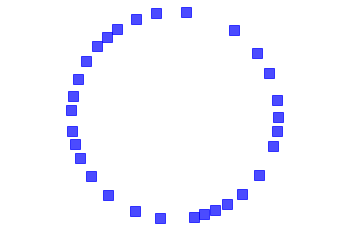

In [339]:
testHighway = improvedHighway(n=30,eps=0.00,distractedp=0.5)
testHighway.animate(frames=100,interval=0.033)

In real life, plotting distracted driving against Number of collisions is more realistic.

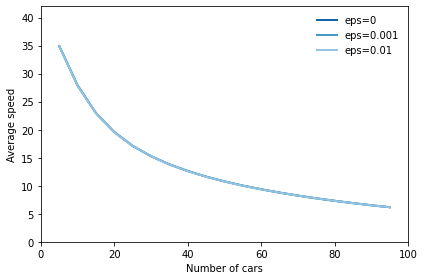

In [340]:
def run_improvedSimulation(eps=0, distractedp=0.0, speed_limit=40, constructor=improvedDriver, iters=100):
    res = []
    for n in range(5, 100, 5):
        highway = improvedHighway(n, eps=eps, length=2000, distractedp=distractedp, constructor=constructor)
        for i in range(iters):
            highway.step()

        highway.set_odometers()
        for i in range(iters):
            highway.step()

        res.append((n, highway.read_odometers() / iters))
    
    return np.transpose(res)

np.random.seed(20)
from utils import set_palette
set_palette('Blues', 4, reverse=True)

for eps in [0.0, 0.001, 0.01]:
    xs, ys = run_improvedSimulation(eps)
    plt.plot(xs, ys, label='eps=%g' % eps)
    
decorate(xlabel='Number of cars',
                 ylabel='Average speed',
                 xlim=[0, 100], ylim=[0, 42])

plt.show('figs/chap10-2')

As we can see, random noise no longer affects the model. Now we will see how much changing the percentage of distracted drivers affects the system.

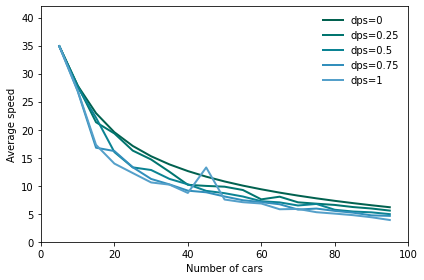

In [346]:

np.random.seed(20)
from utils import set_palette
set_palette('PuBuGn', 10, reverse=True)

for dps in np.linspace(0,1,5):
    xs, ys = run_improvedSimulation(distractedp=dps, speed_limit=100)
    plt.plot(xs, ys, label='dps=%g' % dps)
    
decorate(xlabel='Number of cars',
                 ylabel='Average speed',
                 xlim=[0, 100], ylim=[0, 42])

plt.show('figs/chap10-2')

From this model, we see a smooth curve with no distracted drivers, although the curve becomes more and more "spiky", the more distracted drivers there are. Most likely meaning a car will be distracted and will forget to break, and causing random speedups to match the speed of traffic, moreover causing a spike in the average speed.

Now lets plot distracted p vs number of collisions.

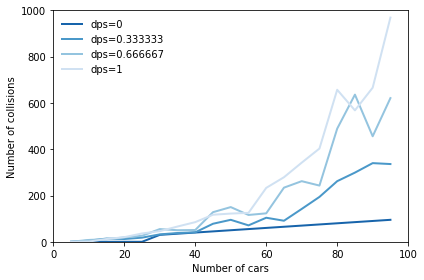

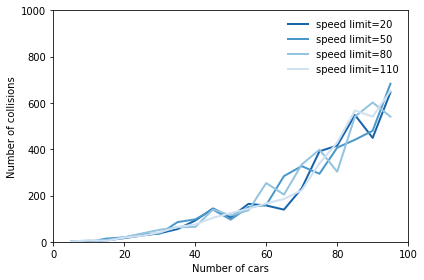

In [347]:
def run_improvedCrashSimulation(eps=0, distractedp=0.0, speed_limit=40, constructor=improvedDriver, iters=25):
    res = []
    for n in range(5, 100, 5):
        highway = improvedHighway(n, eps=eps, distractedp=distractedp, constructor=constructor)
        for i in range(iters):
            highway.step()

        highway.set_odometers()
        for i in range(iters):
            highway.step()

        res.append((n, highway.crashes))
    
    return np.transpose(res)

np.random.seed(20)
from utils import set_palette
set_palette('Blues', 4, reverse=True)

for dps in np.linspace(0,1,4):
    xs, ys = run_improvedCrashSimulation(distractedp=dps)
    plt.plot(xs, ys, label='dps=%g' % dps)
    
decorate(xlabel='Number of cars',
                 ylabel='Number of collisions',
                 xlim=[0, 100], ylim=[0, 1000])

plt.show('figs/chap10-2')


np.random.seed(20)
from utils import set_palette
set_palette('Blues', 4, reverse=True)

for speeds in range(20,120,30):
    xs, ys = run_improvedCrashSimulation(distractedp=0.66, speed_limit=speeds)
    plt.plot(xs, ys, label='speed limit=%g' % speeds)
    
decorate(xlabel='Number of cars',
                 ylabel='Number of collisions',
                 xlim=[0, 100], ylim=[0, 1000])

plt.show('figs/chap10-2')



From this we can see that the number of collisions roughly increases exponentially as the percentage of distracted drivers increases.
We can also see that increasing the speed limit does not affect the amount of collisions. Ofcourse, they will crash faster.

**Conclusion**
From our data, we can see that the most important piece of information is how dangerous it can be to be distracted on the road while driving. The rate of collisions goes up exponentially according to the percentage of those who are distracted on the road.